# Notebook for Toronto Neighborhoods project

In [1]:
# imports
import pandas as pd
import numpy as np
import lxml
import requests
import folium
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.cm as cm
import matplotlib.colors as colors
print('Splines reticulated.')

Splines reticulated.


### 1. Read table from wikipedia

In [2]:
# get Toronto neighborhood table from wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
tables = pd.read_html(url)
neigh = tables[0]
neigh.rename(columns = {'Postal Code': 'PostalCode'}, inplace=True)
print('Table retrieved.')
print(neigh.shape)

Table retrieved.
(180, 3)


In [3]:
# subset to Borough != 'Not assigned'
mask = neigh.Borough != 'Not assigned'
neigh = neigh[mask].reset_index(drop=True)
print("Table subset.")
print(neigh.shape)
neigh.head()

Table subset.
(103, 3)


,PostalCode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [4]:
# check for Neighbourhood == 'Not assigned'
print(neigh[neigh.Neighbourhood == 'Not assigned'].shape)
print('All Neighbourhoods assigned!')

(0, 3)
All Neighbourhoods assigned!


In [5]:
# check for duplicate PostalCodes
m = neigh['PostalCode'].value_counts().max()
if m == 1:
    print('No duplicate PostalCodes found!')
else:
    print('***DUPLICATES***FOUND***')

No duplicate PostalCodes found!


### 2. Add geocoding info to the neighborhoods

In [6]:
# note: the geocoder package did not work so will use the CSV file
geo = pd.read_csv('..\..\data\Geospatial_Coordinates.csv')
geo.rename(columns = {'Postal Code': 'PostalCode'}, inplace=True)
neigh_geo = neigh.merge(geo, on='PostalCode')
neigh_geo.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [7]:
# visualize postal codes
latitude = neigh_geo.Latitude.mean()
longitude = neigh_geo.Longitude.mean()
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, postalcode, borough, neighborhood in zip(neigh_geo['Latitude'], 
                                                       neigh_geo['Longitude'], 
                                                       neigh_geo['PostalCode'], 
                                                       neigh_geo['Borough'], 
                                                       neigh_geo['Neighbourhood']):
    label = '{}, {}, {}'.format(neighborhood, borough, postalcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [8]:
# subset to boroughs containing "Toronto"
mask = neigh_geo.Borough.str.contains('Toronto')
toronto_geo = neigh_geo[mask].reset_index(drop=True)
print(toronto_geo.shape)
toronto_geo.head()

(39, 5)


,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [9]:
# visualize postal codes where borough contains "Toronto"
latitude = toronto_geo.Latitude.mean()
longitude = toronto_geo.Longitude.mean()
map_toronto_geo = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, postalcode, borough, neighborhood in zip(toronto_geo['Latitude'], 
                                                       toronto_geo['Longitude'], 
                                                       toronto_geo['PostalCode'], 
                                                       toronto_geo['Borough'], 
                                                       toronto_geo['Neighbourhood']):
    label = '{}, {}, {}'.format(neighborhood, borough, postalcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto_geo)  
    
map_toronto_geo

### 3. Analyze and cluster neighborhoods

In [10]:
# set foursquare credentials and version
CLIENT_ID = os.getenv('FOURSQUARE_CLIENT_ID')
CLIENT_SECRET = os.getenv('FOURSQUARE_CLIENT_SECRET')
VERSION = '20180605'
LIMIT = 100

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode', 
                  'PostalCode Latitude', 
                  'PostalCode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
toronto_venues = getNearbyVenues(names=toronto_geo['PostalCode'],
                                 latitudes=toronto_geo['Latitude'],
                                 longitudes=toronto_geo['Longitude']
                                )
print("All done!")

All done!


In [13]:
print(toronto_venues.shape)
toronto_venues.head()

(1601, 7)


,PostalCode,PostalCode Latitude,PostalCode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M5A,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
1,M5A,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
2,M5A,43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,M5A,43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,M5A,43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


In [14]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 236 uniques categories.


Lots of coffee shops!
count            1601
unique            236
top       Coffee Shop
freq              152
Name: Venue Category, dtype: object
Coffee Shop           0.094941
Café                  0.052467
Restaurant            0.031230
Italian Restaurant    0.026234
Hotel                 0.023111
Name: Venue Category, dtype: float64


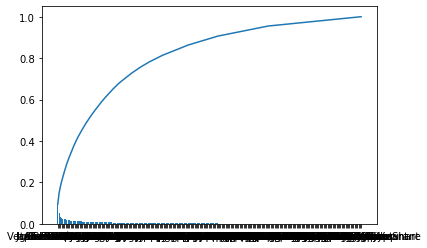

In [15]:
print("Lots of coffee shops!")
print(toronto_venues['Venue Category'].describe())
t = toronto_venues['Venue Category'].value_counts(normalize=True)
print(t.head())
x = t.index.values
h = t.values
c = h.cumsum()
plt.bar(x, h)
plt.plot(x, c)

In [16]:
# derive features with one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add postal code column back to dataframe
toronto_onehot['PostalCode'] = toronto_venues['PostalCode'] 

# move postal code column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

postal_code_counts = toronto_onehot.PostalCode.value_counts().reset_index()
postal_code_counts.columns = ['PostalCode', 'Count']
print(postal_code_counts[['Count']].quantile([0,0.05,0.1,0.25,0.33,0.5,0.67,0.75,0.9,0.95,1]))
toronto_hot_counts = toronto_onehot.merge(postal_code_counts, on='PostalCode')

print(toronto_hot_counts.shape)
print('Some postal codes only have a few venues.')
print('Some have up to 100.')

       Count
0.00    2.00
0.05    3.00
0.10    4.00
0.25   15.00
0.33   17.00
0.50   33.00
0.67   43.92
0.75   63.00
0.90  100.00
0.95  100.00
1.00  100.00
(1601, 238)
Some postal codes only have a few venues.
Some have up to 100.


In [17]:
# group by postal code and take mean by venue type
toronto_grouped = toronto_hot_counts.groupby('PostalCode').mean().reset_index()
print(toronto_grouped.shape)
toronto_grouped.head()

(39, 238)


,PostalCode,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio,Count
0,M4E,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.00000,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.000000,6
1,M4K,0.0,0.0,0.0,0.0,0.0,0.0,0.023810,0.0,0.0,...,0.02381,0.0,0.023810,0.0,0.0,0.0,0.0,0.0,0.023810,42
2,M4L,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,21
3,M4M,0.0,0.0,0.0,0.0,0.0,0.0,0.054054,0.0,0.0,...,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.027027,37
4,M4N,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,3


In [18]:
# define function to sort venue type by frequency of occurence
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:-1]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [19]:
# create the dataframe containint top ten venue types for each postal code
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['PostalCode'] = toronto_grouped['PostalCode']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,PostalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,Pub,Health Food Store,Trail,Coffee Shop,Asian Restaurant,Neighborhood,Yoga Studio,Dog Run,Diner,Discount Store
1,M4K,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Restaurant,Liquor Store,Indian Restaurant,Spa,Bookstore
2,M4L,Park,Fast Food Restaurant,Brewery,Ice Cream Shop,Steakhouse,Fish & Chips Shop,Italian Restaurant,Light Rail Station,Sandwich Place,Sushi Restaurant
3,M4M,Coffee Shop,American Restaurant,Bakery,Brewery,Café,Gastropub,Yoga Studio,Fish Market,Park,Neighborhood
4,M4N,Park,Bus Line,Swim School,Farmers Market,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


In [20]:
# standardize values
mask = toronto_grouped.Count > 19
X = toronto_grouped[mask].drop('PostalCode', 1)
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)

In [21]:
# determine best number of clusters
toronto_grouped_clustering = cluster_dataset
n_clus = [2,3,4,5,6,7]

for k in n_clus:
    print("K: ",k)
    # run k-means clustering
    print("Clusters:")
    kmeans = KMeans(n_clusters=k).fit(toronto_grouped_clustering)
    # check cluster labels generated for each row in the dataframe
    print(pd.DataFrame(kmeans.labels_).value_counts())
    # Calculate silhouette_score
    print("Silhouette: ",silhouette_score(toronto_grouped_clustering, kmeans.labels_),"\n")

K:  2
Clusters:
1    14
0    11
dtype: int64
Silhouette:  0.03709193361529528 

K:  3
Clusters:
2    13
1     7
0     5
dtype: int64
Silhouette:  0.014671593004639523 

K:  4
Clusters:
2    13
1     8
3     3
0     1
dtype: int64
Silhouette:  0.0262214329065957 

K:  5
Clusters:
3    9
1    8
4    5
2    2
0    1
dtype: int64
Silhouette:  0.04904483358567263 

K:  6
Clusters:
2    9
1    6
0    5
4    3
5    1
3    1
dtype: int64
Silhouette:  0.026926617580301695 

K:  7
Clusters:
2    10
5     6
6     3
1     3
4     1
3     1
0     1
dtype: int64
Silhouette:  0.02120436831059789 



In [22]:
# run k-means clustering
print('Just going to pick 4 and set a seed... --\(:/)/--')
kclusters = 4
kmeans = KMeans(n_clusters=kclusters,random_state=4444).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
print(pd.DataFrame(kmeans.labels_).value_counts())

# Calculate silhouette_score
print("Silhouette: ",silhouette_score(toronto_grouped_clustering, kmeans.labels_),"\n")

Just going to pick 4 and set a seed... --\(:/)/--
1    10
2     8
0     5
3     2
dtype: int64
Silhouette:  0.045093406562617115 



In [23]:
# add clustering labels
labeled = neighborhoods_venues_sorted[mask]
labeled.head()
labeled.insert(0, 'Cluster Labels', kmeans.labels_)
labeled.head()

,Cluster Labels,PostalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,0,M4K,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Restaurant,Liquor Store,Indian Restaurant,Spa,Bookstore
2,0,M4L,Park,Fast Food Restaurant,Brewery,Ice Cream Shop,Steakhouse,Fish & Chips Shop,Italian Restaurant,Light Rail Station,Sandwich Place,Sushi Restaurant
3,2,M4M,Coffee Shop,American Restaurant,Bakery,Brewery,Café,Gastropub,Yoga Studio,Fish Market,Park,Neighborhood
7,0,M4S,Dessert Shop,Sandwich Place,Café,Italian Restaurant,Gym,Coffee Shop,Sushi Restaurant,Pizza Place,Pharmacy,Indoor Play Area
11,0,M4X,Coffee Shop,Café,Pub,Italian Restaurant,Park,Bakery,Pizza Place,Chinese Restaurant,Restaurant,General Entertainment


In [24]:
# add clustering labels to toronto_geo
toronto_geo_merged = toronto_geo.merge(labeled, on='PostalCode')
print(toronto_geo_merged.shape)
print(toronto_geo_merged['Cluster Labels'].value_counts())
toronto_geo_merged.head()

(25, 16)
1    10
2     8
0     5
3     2
Name: Cluster Labels, dtype: int64


,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2,Coffee Shop,Bakery,Park,Pub,Breakfast Spot,Theater,Café,Yoga Studio,Electronics Store,Restaurant
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,2,Coffee Shop,Sushi Restaurant,Yoga Studio,Bank,Beer Bar,Smoothie Shop,Sandwich Place,Burger Joint,Burrito Place,Café
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,3,Clothing Store,Coffee Shop,Middle Eastern Restaurant,Italian Restaurant,Cosmetics Shop,Japanese Restaurant,Bubble Tea Shop,Café,Ramen Restaurant,Electronics Store
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1,Café,Coffee Shop,Gastropub,American Restaurant,Cocktail Bar,Clothing Store,Cosmetics Shop,Italian Restaurant,Gym,Restaurant
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,1,Coffee Shop,Cocktail Bar,Farmers Market,Beer Bar,Bakery,Seafood Restaurant,Restaurant,Cheese Shop,Eastern European Restaurant,Fish Market


In [25]:
# create map
latitude = toronto_geo_merged.Latitude.mean()
longitude = toronto_geo_merged.Longitude.mean()
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_geo_merged['Latitude'], 
                                  toronto_geo_merged['Longitude'], 
                                  toronto_geo_merged['Neighbourhood'], 
                                  toronto_geo_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
print('Radial clusters?')
map_clusters

Radial clusters?


### 4. Examine Clusters

In [26]:
# cluster 1 - downtown 
print('Downtown cluster:')
mask0 = toronto_geo_merged['Cluster Labels'] == 1
toronto_geo_merged.loc[mask0, toronto_geo_merged.columns[[0,1] + list(range(5, toronto_geo_merged.shape[1]))]]

Downtown cluster:


,PostalCode,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,M5C,Downtown Toronto,1,Café,Coffee Shop,Gastropub,American Restaurant,Cocktail Bar,Clothing Store,Cosmetics Shop,Italian Restaurant,Gym,Restaurant
4,M5E,Downtown Toronto,1,Coffee Shop,Cocktail Bar,Farmers Market,Beer Bar,Bakery,Seafood Restaurant,Restaurant,Cheese Shop,Eastern European Restaurant,Fish Market
6,M5H,Downtown Toronto,1,Coffee Shop,Café,Restaurant,Deli / Bodega,Gym,Thai Restaurant,Clothing Store,Bakery,Asian Restaurant,Salad Place
7,M5J,Downtown Toronto,1,Coffee Shop,Aquarium,Hotel,Café,Italian Restaurant,Fried Chicken Joint,Sporting Goods Shop,Restaurant,Brewery,Scenic Lookout
8,M6J,West Toronto,1,Bar,Café,Vegetarian / Vegan Restaurant,Restaurant,Asian Restaurant,Men's Store,Yoga Studio,Beer Store,Italian Restaurant,Boutique
10,M5K,Downtown Toronto,1,Coffee Shop,Hotel,Café,Italian Restaurant,Restaurant,Seafood Restaurant,Salad Place,American Restaurant,Japanese Restaurant,Bakery
13,M5L,Downtown Toronto,1,Coffee Shop,Restaurant,Hotel,Café,Italian Restaurant,Gym,American Restaurant,Cocktail Bar,Seafood Restaurant,Japanese Restaurant
20,M5T,Downtown Toronto,1,Café,Vegetarian / Vegan Restaurant,Coffee Shop,Vietnamese Restaurant,Bakery,Mexican Restaurant,Bar,Farmers Market,Gaming Cafe,Park
21,M5W,Downtown Toronto,1,Coffee Shop,Seafood Restaurant,Hotel,Restaurant,Café,Beer Bar,Cocktail Bar,Japanese Restaurant,Italian Restaurant,Creperie
23,M5X,Downtown Toronto,1,Coffee Shop,Café,Hotel,Restaurant,Gym,Japanese Restaurant,Salad Place,Steakhouse,American Restaurant,Asian Restaurant


In [27]:
# cluster 3 - north downtown
print('North Downtown Cluster:')
mask1 = toronto_geo_merged['Cluster Labels'] == 3
toronto_geo_merged.loc[mask1, toronto_geo_merged.columns[[0,1] + list(range(5, toronto_geo_merged.shape[1]))]]

North Downtown Cluster:


,PostalCode,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M5B,Downtown Toronto,3,Clothing Store,Coffee Shop,Middle Eastern Restaurant,Italian Restaurant,Cosmetics Shop,Japanese Restaurant,Bubble Tea Shop,Café,Ramen Restaurant,Electronics Store
5,M5G,Downtown Toronto,3,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Bubble Tea Shop,Burger Joint,Salad Place,Poke Place,Portuguese Restaurant,Ramen Restaurant


In [28]:
# cluster 2 - inner ring
print('Inner Ring Cluster:')
mask2 = toronto_geo_merged['Cluster Labels'] == 2
toronto_geo_merged.loc[mask2, toronto_geo_merged.columns[[0,1] + list(range(5, toronto_geo_merged.shape[1]))]]

Inner Ring Cluster:


,PostalCode,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,2,Coffee Shop,Bakery,Park,Pub,Breakfast Spot,Theater,Café,Yoga Studio,Electronics Store,Restaurant
1,M7A,Downtown Toronto,2,Coffee Shop,Sushi Restaurant,Yoga Studio,Bank,Beer Bar,Smoothie Shop,Sandwich Place,Burger Joint,Burrito Place,Café
11,M6K,West Toronto,2,Café,Nightclub,Breakfast Spot,Coffee Shop,Performing Arts Venue,Italian Restaurant,Intersection,Bar,Bakery,Restaurant
14,M4M,East Toronto,2,Coffee Shop,American Restaurant,Bakery,Brewery,Café,Gastropub,Yoga Studio,Fish Market,Park,Neighborhood
15,M6P,West Toronto,2,Café,Mexican Restaurant,Thai Restaurant,Grocery Store,Furniture / Home Store,Bookstore,Fast Food Restaurant,Flea Market,Cajun / Creole Restaurant,Speakeasy
18,M5S,Downtown Toronto,2,Café,Bar,Japanese Restaurant,Bookstore,Bakery,Yoga Studio,Beer Bar,Beer Store,Sandwich Place,Restaurant
19,M6S,West Toronto,2,Coffee Shop,Café,Pizza Place,Italian Restaurant,Pub,Sushi Restaurant,Yoga Studio,Latin American Restaurant,Indie Movie Theater,Fish & Chips Shop
24,M4Y,Downtown Toronto,2,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Restaurant,Gay Bar,Mediterranean Restaurant,Fast Food Restaurant,Pub,Yoga Studio,Hotel


In [29]:
# cluster 0 - outer ring
print('Outer Ring Cluster:')
mask3 = toronto_geo_merged['Cluster Labels'] == 3
toronto_geo_merged.loc[mask3, toronto_geo_merged.columns[[1] + list(range(5, toronto_geo_merged.shape[1]))]]

Outer Ring Cluster:


,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,3,Clothing Store,Coffee Shop,Middle Eastern Restaurant,Italian Restaurant,Cosmetics Shop,Japanese Restaurant,Bubble Tea Shop,Café,Ramen Restaurant,Electronics Store
5,Downtown Toronto,3,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Bubble Tea Shop,Burger Joint,Salad Place,Poke Place,Portuguese Restaurant,Ramen Restaurant
